In [ ]:
import numpy as np
import pandas as pd
from sklearn import preprocessing
import matplotlib.pyplot as plt
import seaborn as sns

# machine learning
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB

import dataProcess as dp

In [ ]:
trainPath = '../data/train.csv'
testPath = '../data/test.csv'
x_train, y_train,x_test = dp.loadData(trainPath,testPath)

In [ ]:
X_train = x_train
Y_train = y_train
X_test = x_test

In [ ]:
# Logistic Regression

logreg = LogisticRegression(max_iter = 200)

logreg.fit(x_train, y_train)

y_pred = logreg.predict(x_test)

logreg.score(x_train, y_train)

In [ ]:
# Random Forests

random_forest = RandomForestClassifier(n_estimators=100)

random_forest.fit(X_train, Y_train)

Y_pred = random_forest.predict(X_test)

random_forest.score(X_train, Y_train)

In [ ]:
print(Y_pred)

In [ ]:
knn = KNeighborsClassifier(n_neighbors = 3)

knn.fit(X_train, Y_train)

Y_pred = knn.predict(X_test)

knn.score(X_train, Y_train)

In [ ]:
# Gaussian Naive Bayes

gaussian = GaussianNB()

gaussian.fit(X_train, Y_train)

Y_pred = gaussian.predict(X_test)

gaussian.score(X_train, Y_train)

In [ ]:
# Support Vector Machines

svc = SVC()

svc.fit(X_train, Y_train)

Y_pred = svc.predict(X_test)

svc.score(X_train, Y_train)

In [ ]:
sample = pd.read_csv('../data/gender_submission.csv')
sample.Survived = Y_pred.astype(int)
sample.to_csv('../outputs/mySubmission.csv',index=False)

# ensemble models

In [ ]:
# Load in our libraries
import pandas as pd
import numpy as np
import re
import sklearn
import xgboost as xgb
import matplotlib.pyplot as plt


# Going to use these 5 base models for the stacking
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier
from sklearn.svm import SVC
from sklearn.cross_validation import KFold;
import dataProcess as dp

In [ ]:
trainPath = '../data/train.csv'
testPath = '../data/test.csv'
x_train, y_train,x_test = dp.loadData(trainPath,testPath)

In [ ]:
# Some useful parameters which will come in handy later on
ntrain = x_train.shape[0]
ntest = x_test.shape[0]
SEED = 0 # for reproducibility
NFOLDS = 5 # set folds for out-of-fold prediction
kf = KFold(ntrain, n_folds= NFOLDS, random_state=SEED)

# Class to extend the Sklearn classifier
class SklearnHelper(object):
    def __init__(self, clf, seed=0, params=None):
        params['random_state'] = seed
        self.clf = clf(**params)

    def train(self, x_train, y_train):
        self.clf.fit(x_train, y_train)

    def predict(self, x):
        return self.clf.predict(x)
    
    def fit(self,x,y):
        return self.clf.fit(x,y)
    
    def feature_importances(self,x,y):
        print(self.clf.fit(x,y).feature_importances_)
    
# Class to extend XGboost classifer

In [ ]:
def get_oof(clf, x_train, y_train, x_test):
    oof_train = np.zeros((ntrain,))
    oof_test = np.zeros((ntest,))
    oof_test_skf = np.empty((NFOLDS, ntest))

    for i, (train_index, test_index) in enumerate(kf):
        x_tr = x_train[train_index]
        y_tr = y_train[train_index]
        x_te = x_train[test_index]

        clf.train(x_tr, y_tr)

        oof_train[test_index] = clf.predict(x_te)
        oof_test_skf[i, :] = clf.predict(x_test)

    oof_test[:] = oof_test_skf.mean(axis=0)
    return oof_train.reshape(-1, 1), oof_test.reshape(-1, 1)

In [ ]:
# Put in our parameters for said classifiers
# Random Forest parameters
rf_params = {
    'n_jobs': -1,
    'n_estimators': 500,
     'warm_start': True, 
     #'max_features': 0.2,
    'max_depth': 6,
    'min_samples_leaf': 2,
    'max_features' : 'sqrt',
    'verbose': 0
}

# Extra Trees Parameters
et_params = {
    'n_jobs': -1,
    'n_estimators':500,
    #'max_features': 0.5,
    'max_depth': 8,
    'min_samples_leaf': 2,
    'verbose': 0
}

# AdaBoost parameters
ada_params = {
    'n_estimators': 500,
    'learning_rate' : 0.75
}

# Gradient Boosting parameters
gb_params = {
    'n_estimators': 500,
     #'max_features': 0.2,
    'max_depth': 5,
    'min_samples_leaf': 2,
    'verbose': 0
}

# Support Vector Classifier parameters 
svc_params = {
    'kernel' : 'linear',
    'C' : 0.025
    }

In [ ]:
# Create 5 objects that represent our 4 models
rf = SklearnHelper(clf=RandomForestClassifier, seed=SEED, params=rf_params)
et = SklearnHelper(clf=ExtraTreesClassifier, seed=SEED, params=et_params)
ada = SklearnHelper(clf=AdaBoostClassifier, seed=SEED, params=ada_params)
gb = SklearnHelper(clf=GradientBoostingClassifier, seed=SEED, params=gb_params)
svc = SklearnHelper(clf=SVC, seed=SEED, params=svc_params)

In [ ]:
# Create our OOF train and test predictions. These base results will be used as new features
et_oof_train, et_oof_test = get_oof(et, x_train, y_train, x_test) # Extra Trees
rf_oof_train, rf_oof_test = get_oof(rf,x_train, y_train, x_test) # Random Forest
ada_oof_train, ada_oof_test = get_oof(ada, x_train, y_train, x_test) # AdaBoost 
gb_oof_train, gb_oof_test = get_oof(gb,x_train, y_train, x_test) # Gradient Boost
svc_oof_train, svc_oof_test = get_oof(svc,x_train, y_train, x_test) # Support Vector Classifier

print("Training is complete")

In [ ]:
base_predictions_train = pd.DataFrame( {'RandomForest': rf_oof_train.ravel(),
     'ExtraTrees': et_oof_train.ravel(),
     'AdaBoost': ada_oof_train.ravel(),
      'GradientBoost': gb_oof_train.ravel()
    })
base_predictions_train.head()

In [ ]:
print(et_oof_test.ravel())

In [ ]:
x_train = np.concatenate(( et_oof_train, rf_oof_train, ada_oof_train, gb_oof_train, svc_oof_train), axis=1)
x_test = np.concatenate(( et_oof_test, rf_oof_test, ada_oof_test, gb_oof_test, svc_oof_test), axis=1)

In [ ]:
param = 

gbm = xgb.XGBClassifier(
    learning_rate = 0.02,
 n_estimators= 200,
 max_depth= 3,
 min_child_weight= 2,
 #gamma=1,
 gamma=0.9,                        
 subsample=1,
 colsample_bytree=0.8,
 objective= 'binary:logistic',
 nthread= -1,
 scale_pos_weight=1).fit(x_train, y_train)
predictions = gbm.predict(x_test)

In [ ]:
print(predictions)

In [ ]:
sample = pd.read_csv('../data/gender_submission.csv')
sample.Survived = predictions.astype(int)
sample.to_csv('../outputs/xgboostSubmission.csv',index=False)

In [ ]:
print(y_train)

# grid search


In [ ]:
import pandas as pd
import numpy as np
import matplotlib as plt

import xgboost as xgb
from sklearn import preprocessing

from sklearn.cross_validation import StratifiedKFold
from sklearn.grid_search import GridSearchCV
import dataProcess as dp

In [ ]:
trainPath = '../data/train.csv'
testPath = '../data/test.csv'
x_train, y_train,x_test = dp.loadData(trainPath,testPath)

In [ ]:
xgb_model = xgb.XGBClassifier()
knn = KNeighborsClassifier(n_neighbors=10)

parameters = {'nthread': [4],
             'objective': ['binary:logistic'],
             'learning_rate': [0.01,0.03,0.05],
             'max_depth': [4, 5, 6],
             'min_child_weight': [11],
             'silent': [1],
             'subsample': [0.8],
             'colsample_bytree': [0.7],
             'n_estimators': [2000],
             'seed': [1337],}
clf = GridSearchCV(xgb_model, param_grid=parameters, n_jobs=5,
                  cv=StratifiedKFold(y_train, n_folds=10, shuffle=True),
                  scoring='accuracy', verbose=2, refit=True)

clf.fit(x_train, y_train)

best_parameters, score, _ = max(clf.grid_scores_, key=lambda x: x[1])
print('accuracy_score ', score)

for param_name in sorted(best_parameters.keys()):
    print("%s: %r" % (param_name, best_parameters[param_name]))



In [ ]:
test_probs = clf.predict_proba(x_test)[:, 1]

In [ ]:
print(test_probs)

In [ ]:
test_result = clf.predict(x_test)

In [ ]:
print(test_result)

In [ ]:
sample = pd.read_csv('../data/gender_submission.csv')
sample.Survived = test_result.astype(int)
sample.to_csv('../outputs/gridSearchCVSubmission.csv',index=False)

# more ML package


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from collections import Counter

from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier, VotingClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold, learning_curve

sns.set(style='white', context='notebook', palette='deep')
import dataProcess as dp

In [3]:
# Load data
##### Load train and Test set

train = pd.read_csv("../data/train.csv")
test = pd.read_csv("../data/test.csv")
IDtest = test["PassengerId"]

In [4]:
def detect_outliers(df,n,features):
    """
    Takes a dataframe df of features and returns a list of the indices
    corresponding to the observations containing more than n outliers according
    to the Tukey method.
    """
    outlier_indices = []
    
    # iterate over features(columns)
    for col in features:
        # 1st quartile (25%)
        Q1 = np.percentile(df[col], 25)
        # 3rd quartile (75%)
        Q3 = np.percentile(df[col],75)
        # Interquartile range (IQR)
        IQR = Q3 - Q1
        
        # outlier step
        outlier_step = 1.5 * IQR
        
        # Determine a list of indices of outliers for feature col
        outlier_list_col = df[(df[col] < Q1 - outlier_step) | (df[col] > Q3 + outlier_step )].index
        
        # append the found outlier indices for col to the list of outlier indices 
        outlier_indices.extend(outlier_list_col)
        
    # select observations containing more than 2 outliers
    outlier_indices = Counter(outlier_indices)        
    multiple_outliers = list( k for k, v in outlier_indices.items() if v > n )
    
    return multiple_outliers   

# detect outliers from Age, SibSp , Parch and Fare
Outliers_to_drop = detect_outliers(train,2,["Age","SibSp","Parch","Fare"])

# Drop outliers
train = train.drop(Outliers_to_drop, axis = 0).reset_index(drop=True)

/home/liwb/anaconda3/lib/python3.5/site-packages/numpy/lib/function_base.py:3834: RuntimeWarning: Invalid value encountered in percentile
  RuntimeWarning)


In [5]:
## Join train and test datasets in order to obtain the same number of features during categorical conversion
train_len = len(train)
dataset =  pd.concat(objs=[train, test], axis=0).reset_index(drop=True)

# Fill empty and NaNs values with NaN
dataset = dataset.fillna(np.nan)

# Check for Null values
dataset.isnull().sum()



Age             256
Cabin          1007
Embarked          2
Fare              1
Name              0
Parch             0
PassengerId       0
Pclass            0
Sex               0
SibSp             0
Survived        418
Ticket            0
dtype: int64

In [6]:
#Fill Fare missing values with the median value
dataset["Fare"] = dataset["Fare"].fillna(dataset["Fare"].median())

# Apply log to Fare to reduce skewness distribution
dataset["Fare"] = dataset["Fare"].map(lambda i: np.log(i) if i > 0 else 0)

In [7]:
train[["Sex","Survived"]].groupby('Sex').mean()

,Survived
Sex,
female,0.747573
male,0.190559


In [8]:
#Fill Embarked nan values of dataset set with 'S' most frequent value
dataset["Embarked"] = dataset["Embarked"].fillna("S")

In [9]:
# convert Sex into categorical value 0 for male and 1 for female
dataset["Sex"] = dataset["Sex"].map({"male": 0, "female":1})

In [10]:
## Fill Age with the median age of similar rows according to Pclass, Parch and SibSp
# Index of NaN age rows
index_NaN_age = list(dataset["Age"][dataset["Age"].isnull()].index)

for i in index_NaN_age :
    age_med = dataset["Age"].median()
    age_pred = dataset["Age"][((dataset['SibSp'] == dataset.iloc[i]["SibSp"]) & (dataset['Parch'] == dataset.iloc[i]["Parch"]) & (dataset['Pclass'] == dataset.iloc[i]["Pclass"]))].median()
    if not np.isnan(age_pred) :
        dataset['Age'].iloc[i] = age_pred
    else :
        dataset['Age'].iloc[i] = age_med

/home/liwb/anaconda3/lib/python3.5/site-packages/pandas/core/indexing.py:132: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


In [11]:
# Get Title from Name
dataset_title = [i.split(",")[1].split(".")[0].strip() for i in dataset["Name"]]
dataset["Title"] = pd.Series(dataset_title)
dataset["Title"].head()

0      Mr
1     Mrs
2    Miss
3     Mrs
4      Mr
Name: Title, dtype: object

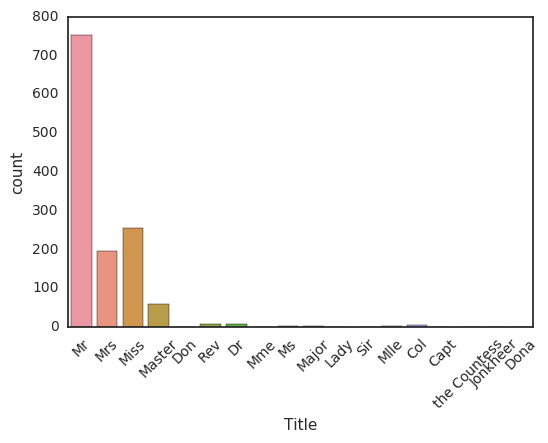

In [12]:
g = sns.countplot(x="Title",data=dataset)
g = plt.setp(g.get_xticklabels(), rotation=45) 

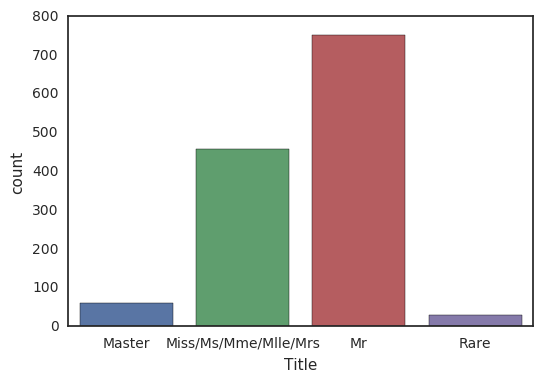

In [13]:
# Convert to categorical values Title 
dataset["Title"] = dataset["Title"].replace(['Lady', 'the Countess','Countess','Capt', 'Col','Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')
dataset["Title"] = dataset["Title"].map({"Master":0, "Miss":1, "Ms" : 1 , "Mme":1, "Mlle":1, "Mrs":1, "Mr":2, "Rare":3})
dataset["Title"] = dataset["Title"].astype(int)
g = sns.countplot(dataset["Title"])
g = g.set_xticklabels(["Master","Miss/Ms/Mme/Mlle/Mrs","Mr","Rare"])

In [14]:
# Drop Name variable
dataset.drop(labels = ["Name"], axis = 1, inplace = True)

In [15]:
dataset.head()

,Age,Cabin,Embarked,Fare,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket,Title
0,22.0,NaN,S,1.981001,0,1,3,0,1,0.0,A/5 21171,2
1,38.0,C85,C,4.266662,0,2,1,1,1,1.0,PC 17599,1
2,26.0,NaN,S,2.070022,0,3,3,1,0,1.0,STON/O2. 3101282,1
3,35.0,C123,S,3.972177,0,4,1,1,1,1.0,113803,1
4,35.0,NaN,S,2.085672,0,5,3,0,0,0.0,373450,2


In [16]:
# Create a family size descriptor from SibSp and Parch
dataset["Fsize"] = dataset["SibSp"] + dataset["Parch"] + 1
# Create new feature of family size
dataset['Single'] = dataset['Fsize'].map(lambda s: 1 if s == 1 else 0)
dataset['SmallF'] = dataset['Fsize'].map(lambda s: 1 if  s == 2  else 0)
dataset['MedF'] = dataset['Fsize'].map(lambda s: 1 if 3 <= s <= 4 else 0)
dataset['LargeF'] = dataset['Fsize'].map(lambda s: 1 if s >= 5 else 0)

# convert to indicator values Title and Embarked 
dataset = pd.get_dummies(dataset, columns = ["Title"])
dataset = pd.get_dummies(dataset, columns = ["Embarked"], prefix="Em")

dataset.head()

,Age,Cabin,Fare,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket,...,SmallF,MedF,LargeF,Title_0,Title_1,Title_2,Title_3,Em_C,Em_Q,Em_S
0,22.0,NaN,1.981001,0,1,3,0,1,0.0,A/5 21171,...,1,0,0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
1,38.0,C85,4.266662,0,2,1,1,1,1.0,PC 17599,...,1,0,0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
2,26.0,NaN,2.070022,0,3,3,1,0,1.0,STON/O2. 3101282,...,0,0,0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
3,35.0,C123,3.972177,0,4,1,1,1,1.0,113803,...,1,0,0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
4,35.0,NaN,2.085672,0,5,3,0,0,0.0,373450,...,0,0,0,0.0,0.0,1.0,0.0,0.0,0.0,1.0


In [17]:
dataset["Cabin"][dataset["Cabin"].notnull()].head()
# Replace the Cabin number by the type of cabin 'X' if not
dataset["Cabin"] = pd.Series([i[0] if not pd.isnull(i) else 'X' for i in dataset['Cabin'] ])

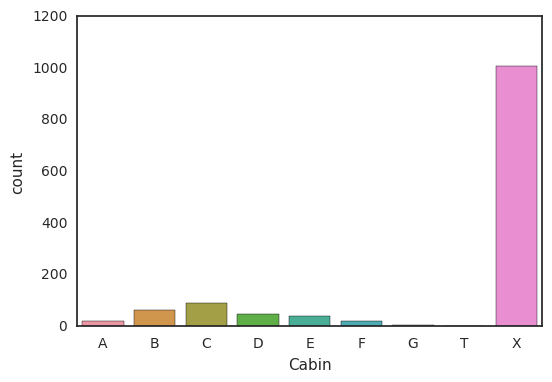

In [18]:
g = sns.countplot(dataset["Cabin"],order=['A','B','C','D','E','F','G','T','X'])

In [19]:
dataset = pd.get_dummies(dataset, columns = ["Cabin"],prefix="Cabin")

In [20]:
## Treat Ticket by extracting the ticket prefix. When there is no prefix it returns X. 

Ticket = []
for i in list(dataset.Ticket):
    if not i.isdigit() :
        Ticket.append(i.replace(".","").replace("/","").strip().split(' ')[0]) #Take prefix
    else:
        Ticket.append("X")
        
dataset["Ticket"] = Ticket
dataset["Ticket"].head()

0        A5
1        PC
2    STONO2
3         X
4         X
Name: Ticket, dtype: object

In [21]:
dataset = pd.get_dummies(dataset, columns = ["Ticket"], prefix="T")
# Create categorical values for Pclass
dataset["Pclass"] = dataset["Pclass"].astype("category")
dataset = pd.get_dummies(dataset, columns = ["Pclass"],prefix="Pc")
# Drop useless variables 
dataset.drop(labels = ["PassengerId"], axis = 1, inplace = True)
dataset.head()

,Age,Fare,Parch,Sex,SibSp,Survived,Fsize,Single,SmallF,MedF,...,T_STONO,T_STONO2,T_STONOQ,T_SWPP,T_WC,T_WEP,T_X,Pc_1,Pc_2,Pc_3
0,22.0,1.981001,0,0,1,0.0,2,0,1,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,38.0,4.266662,0,1,1,1.0,2,0,1,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,26.0,2.070022,0,1,0,1.0,1,1,0,0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,35.0,3.972177,0,1,1,1.0,2,0,1,0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
4,35.0,2.085672,0,0,0,0.0,1,1,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0


In [22]:
## Separate train dataset and test dataset

train = dataset[:train_len]
test = dataset[train_len:]
test.drop(labels=["Survived"],axis = 1,inplace=True)

/home/liwb/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [23]:
## Separate train features and label 

train["Survived"] = train["Survived"].astype(int)

Y_train = train["Survived"]

X_train = train.drop(labels = ["Survived"],axis = 1)

/home/liwb/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


In [24]:
# Cross validate model with Kfold stratified cross val
kfold = StratifiedKFold(n_splits=10)

/home/liwb/anaconda3/lib/python3.5/site-packages/sklearn/discriminant_analysis.py:387: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/liwb/anaconda3/lib/python3.5/site-packages/sklearn/discriminant_analysis.py:387: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/liwb/anaconda3/lib/python3.5/site-packages/sklearn/discriminant_analysis.py:387: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
/home/liwb/anaconda3/lib/python3.5/site-packages/sklearn/discriminant_analysis.py:387: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


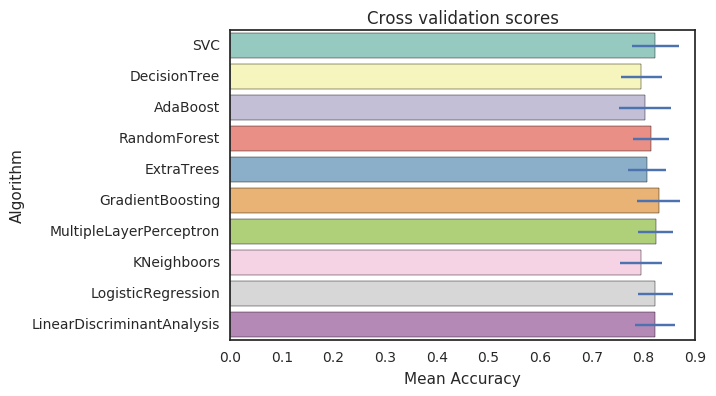

In [25]:
# Modeling step Test differents algorithms 
random_state = 2
classifiers = []
classifiers.append(SVC(random_state=random_state))
classifiers.append(DecisionTreeClassifier(random_state=random_state))
classifiers.append(AdaBoostClassifier(DecisionTreeClassifier(random_state=random_state),random_state=random_state,learning_rate=0.1))
classifiers.append(RandomForestClassifier(random_state=random_state))
classifiers.append(ExtraTreesClassifier(random_state=random_state))
classifiers.append(GradientBoostingClassifier(random_state=random_state))
classifiers.append(MLPClassifier(random_state=random_state))
classifiers.append(KNeighborsClassifier())
classifiers.append(LogisticRegression(random_state = random_state))
classifiers.append(LinearDiscriminantAnalysis())

cv_results = []
for classifier in classifiers :
    cv_results.append(cross_val_score(classifier, X_train, y = Y_train, scoring = "accuracy", cv = kfold, n_jobs=4))

cv_means = []
cv_std = []
for cv_result in cv_results:
    cv_means.append(cv_result.mean())
    cv_std.append(cv_result.std())

cv_res = pd.DataFrame({"CrossValMeans":cv_means,"CrossValerrors": cv_std,"Algorithm":["SVC","DecisionTree","AdaBoost",
"RandomForest","ExtraTrees","GradientBoosting","MultipleLayerPerceptron","KNeighboors","LogisticRegression","LinearDiscriminantAnalysis"]})

g = sns.barplot("CrossValMeans","Algorithm",data = cv_res, palette="Set3",orient = "h",**{'xerr':cv_std})
g.set_xlabel("Mean Accuracy")
g = g.set_title("Cross validation scores")

In [26]:
### META MODELING  WITH ADABOOST, RF, EXTRATREES and GRADIENTBOOSTING

# Adaboost
DTC = DecisionTreeClassifier()

adaDTC = AdaBoostClassifier(DTC, random_state=7)

ada_param_grid = {"base_estimator__criterion" : ["gini", "entropy"],
              "base_estimator__splitter" :   ["best", "random"],
              "algorithm" : ["SAMME","SAMME.R"],
              "n_estimators" :[1,2],
              "learning_rate":  [0.0001, 0.001, 0.01, 0.1, 0.2, 0.3,1.5]}

gsadaDTC = GridSearchCV(adaDTC,param_grid = ada_param_grid, cv=kfold, scoring="accuracy", n_jobs= 4, verbose = 1)

gsadaDTC.fit(X_train,Y_train)

ada_best = gsadaDTC.best_estimator_

Fitting 10 folds for each of 112 candidates, totalling 1120 fits


[Parallel(n_jobs=4)]: Done 848 tasks      | elapsed:    2.4s
[Parallel(n_jobs=4)]: Done 1120 out of 1120 | elapsed:    3.1s finished


In [27]:
gsadaDTC.best_score_

0.82406356413166859

In [28]:
#ExtraTrees 
ExtC = ExtraTreesClassifier()


## Search grid for optimal parameters
ex_param_grid = {"max_depth": [None],
              "max_features": [1, 3, 10],
              "min_samples_split": [2, 3, 10],
              "min_samples_leaf": [1, 3, 10],
              "bootstrap": [False],
              "n_estimators" :[100,300],
              "criterion": ["gini"]}


gsExtC = GridSearchCV(ExtC,param_grid = ex_param_grid, cv=kfold, scoring="accuracy", n_jobs= 4, verbose = 1)

gsExtC.fit(X_train,Y_train)

ExtC_best = gsExtC.best_estimator_

# Best score
gsExtC.best_score_

Fitting 10 folds for each of 54 candidates, totalling 540 fits


[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    4.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   15.0s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:   36.0s
[Parallel(n_jobs=4)]: Done 540 out of 540 | elapsed:   44.8s finished


0.82860385925085134

In [29]:
# RFC Parameters tunning 
RFC = RandomForestClassifier()


## Search grid for optimal parameters
rf_param_grid = {"max_depth": [None],
              "max_features": [1, 3, 10],
              "min_samples_split": [2, 3, 10],
              "min_samples_leaf": [1, 3, 10],
              "bootstrap": [False],
              "n_estimators" :[100,300],
              "criterion": ["gini"]}


gsRFC = GridSearchCV(RFC,param_grid = rf_param_grid, cv=kfold, scoring="accuracy", n_jobs= 4, verbose = 1)

gsRFC.fit(X_train,Y_train)

RFC_best = gsRFC.best_estimator_

# Best score
gsRFC.best_score_

Fitting 10 folds for each of 54 candidates, totalling 540 fits


[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    4.7s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   17.5s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:   40.5s
[Parallel(n_jobs=4)]: Done 540 out of 540 | elapsed:   49.6s finished


0.82973893303064694

In [30]:
# Gradient boosting tunning

GBC = GradientBoostingClassifier()
gb_param_grid = {'loss' : ["deviance"],
              'n_estimators' : [100,200,300],
              'learning_rate': [0.1, 0.05, 0.01],
              'max_depth': [4, 8],
              'min_samples_leaf': [100,150],
              'max_features': [0.3, 0.1] 
              }

gsGBC = GridSearchCV(GBC,param_grid = gb_param_grid, cv=kfold, scoring="accuracy", n_jobs= 4, verbose = 1)

gsGBC.fit(X_train,Y_train)

GBC_best = gsGBC.best_estimator_

# Best score
gsGBC.best_score_

Fitting 10 folds for each of 72 candidates, totalling 720 fits


[Parallel(n_jobs=4)]: Done 144 tasks      | elapsed:    4.7s
[Parallel(n_jobs=4)]: Done 720 out of 720 | elapsed:   21.4s finished


0.83200908059023837

In [32]:
### SVC classifier
SVMC = SVC(probability=True)
svc_param_grid = {'kernel': ['rbf'], 
                  'gamma': [ 0.001, 0.01, 0.1, 1],
                  'C': [1, 10, 50, 100,200,300, 1000]}

gsSVMC = GridSearchCV(SVMC,param_grid = svc_param_grid, cv=kfold, scoring="accuracy", n_jobs= 4, verbose = 1)

gsSVMC.fit(X_train,Y_train)

SVMC_best = gsSVMC.best_estimator_

# Best score
gsSVMC.best_score_

Fitting 10 folds for each of 28 candidates, totalling 280 fits


[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    3.2s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   15.1s
[Parallel(n_jobs=4)]: Done 280 out of 280 | elapsed:   25.0s finished


0.83314415437003408

In [33]:
votingC = VotingClassifier(estimators=[('rfc', RFC_best), ('extc', ExtC_best),
('svc', SVMC_best), ('adac',ada_best),('gbc',GBC_best)], voting='soft', n_jobs=4)

votingC = votingC.fit(X_train, Y_train)



In [34]:
test_Survived = pd.Series(votingC.predict(test), name="Survived")

results = pd.concat([IDtest,test_Survived],axis=1)

results.to_csv("../outputs/ensemble_python_voting.csv",index=False)

# 0842

In [1]:
import pandas as pd
import numpy as np
import warnings
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import preprocessing 
from sklearn.model_selection import GridSearchCV 
from sklearn.ensemble import RandomForestClassifier 
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn import cross_validation

%matplotlib inline
warnings.filterwarnings('ignore')
train = pd.read_csv("../data/train.csv")
test = pd.read_csv("../data/test.csv")

/home/liwb/anaconda3/lib/python3.5/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
train['Sex'] = train['Sex'].apply(lambda x: 1 if x == 'male' else 0)
test['Sex'] = test['Sex'].apply(lambda x: 1 if x == 'male' else 0)

def Name_Title_Code(x):
    if x == 'Mr.':
        return 1
    if (x == 'Mrs.') or (x=='Ms.') or (x=='Lady.') or (x == 'Mlle.') or (x =='Mme'):
        return 2
    if x == 'Miss':
        return 3
    if x == 'Rev.':
        return 4
    return 5

train['Name_Title'] = train['Name'].apply(lambda x: x.split(',')[1]).apply(lambda x: x.split()[0])
test['Name_Title'] = test['Name'].apply(lambda x: x.split(',')[1]).apply(lambda x: x.split()[0]) 

In [3]:
def Age_feature(train, test):
    for i in [train, test]:
        i['Age_Null_Flag'] = i['Age'].apply(lambda x: 1 if pd.isnull(x) else 0)  
        data = train.groupby(['Name_Title', 'Pclass'])['Age']
        i['Age'] = data.transform(lambda x: x.fillna(x.mean()))
#         i['Age'] = data.transform(lambda x: x.fillna(x.median()))
    return train, test

In [4]:
def Family_feature(train, test):
    for i in [train, test]:
        i['Fam_Size'] = np.where((i['SibSp']+i['Parch']) == 0 , 'Solo',
                           np.where((i['SibSp']+i['Parch']) <= 3,'Nuclear', 'Big'))
        del i['SibSp']
        del i['Parch']
    return train, test 

In [5]:
def ticket_grouped(train, test):
    for i in [train, test]:
        i['Ticket_Lett'] = i['Ticket'].apply(lambda x: str(x)[0])
        i['Ticket_Lett'] = i['Ticket_Lett'].apply(lambda x: str(x))
        i['Ticket_Lett'] = np.where((i['Ticket_Lett']).isin(['1', '2', '3', 'S', 'P', 'C', 'A']), i['Ticket_Lett'],
                                    np.where((i['Ticket_Lett']).isin(['W', '4', '7', '6', 'L', '5', '8']),
                                            'Low_ticket', 'Other_ticket'))
        i['Ticket_Len'] = i['Ticket'].apply(lambda x: len(x))
        del i['Ticket']
    return train, test

In [6]:
def Cabin_feature(train, test):
    for i in [train, test]:
        i['Cabin_Letter'] = i['Cabin'].apply(lambda x: str(x)[0])
        del i['Cabin']
    return train, test

In [7]:
def cabin_num(train, test):
    for i in [train, test]:
        i['Cabin_num1'] = i['Cabin'].apply(lambda x: str(x).split(' ')[-1][1:])
        i['Cabin_num1'].replace('an', np.NaN, inplace = True)
        i['Cabin_num1'] = i['Cabin_num1'].apply(lambda x: int(x) if not pd.isnull(x) and x != '' else np.NaN)
        i['Cabin_num'] = pd.qcut(train['Cabin_num1'],3)
    train = pd.concat((train, pd.get_dummies(train['Cabin_num'], prefix = 'Cabin_num')), axis = 1)
    test = pd.concat((test, pd.get_dummies(test['Cabin_num'], prefix = 'Cabin_num')), axis = 1)
    del train['Cabin_num']
    del test['Cabin_num']
    del train['Cabin_num1']
    del test['Cabin_num1']
    return train, test

In [8]:
def embarked_impute(train, test):
    for i in [train, test]:
        i['Embarked'] = i['Embarked'].fillna('S')
    return train, test

In [9]:
test['Fare'].fillna(train['Fare'].mean(), inplace = True)

In [10]:
def dummies(train, test, columns = ['Pclass', 'Sex', 'Embarked', 'Ticket_Lett', 'Cabin_Letter', 'Name_Title', 'Fam_Size']):
    for column in columns:
        train[column] = train[column].apply(lambda x: str(x))
        test[column] = test[column].apply(lambda x: str(x))
        good_cols = [column+'_'+i for i in train[column].unique() if i in test[column].unique()]
        train = pd.concat((train, pd.get_dummies(train[column], prefix = column)[good_cols]), axis = 1)
        test = pd.concat((test, pd.get_dummies(test[column], prefix = column)[good_cols]), axis = 1)
        del train[column]
        del test[column]
    return train, test

In [11]:
def drop(train, test, bye = ['PassengerId']):
    for i in [train, test]:
        for z in bye:
            del i[z]
    return train, test

In [12]:
train, test = Age_feature(train, test)
 
train['Name_Title'] = train['Name_Title'].apply(Name_Title_Code)
test['Name_Title'] = test['Name_Title'].apply(Name_Title_Code)
train = pd.get_dummies(columns = ['Name_Title'], data = train)
test = pd.get_dummies(columns = ['Name_Title'], data = test)

train, test = cabin_num(train, test)

train, test = Cabin_feature(train, test)

train, test = embarked_impute(train, test)

train, test = Family_feature(train, test)

test['Fare'].fillna(train['Fare'].mean(), inplace = True)

train, test = ticket_grouped(train, test)

train, test = dummies(train, test, columns = ['Pclass', 'Sex', 'Embarked', 'Ticket_Lett', 'Fam_Size','Cabin_Letter'])  

train, test = drop(train, test)

In [13]:
train.drop('Name',axis=1,inplace=True)
test.drop('Name',axis=1,inplace=True)

In [21]:
from sklearn.ensemble import RandomForestClassifier
 
rf = RandomForestClassifier(criterion='gini', 
                             n_estimators=700,
                             min_samples_split=16,
                             min_samples_leaf=1,
                             max_features='auto',
                             oob_score=True,
                             random_state=1,
                             n_jobs=-1) 

rf.fit(train.iloc[:, 1:], train.iloc[:, 0])
print("%.4f" % rf.oob_score_)

0.8395


In [22]:

sample = pd.read_csv('../data/gender_submission.csv')
sample.label = rf.predict(test).astype(int)
sample.to_csv("../outputs/mySubmission111.csv", index=False)